Library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import scipy.signal as signal



Graph Utils

In [2]:
def plot_comparison_dhe_bound(original_image, equalized_image, old_bound=[0, 128, 256], new_bound =[0, 128, 256], title="None", dpi=100):
    # Check if the image is grayscale or color
    if len(original_image.shape) == 2:  # Grayscale image
        height, width = original_image.shape
        is_color = False
    else:  # Color image
        height, width, _ = original_image.shape
        is_color = True

    # Calculate figsize based on image size and dpi
    figsize = (width * 2 / dpi, height * 2 / dpi)

    # Plot the original and equalized images at their actual size
    plt.figure(figsize=figsize, dpi=dpi)

    # Original Image
    plt.subplot(2, 2, 1)
    if is_color:
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Equalized Image
    plt.subplot(2, 2, 2)
    if is_color:
        plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(equalized_image, cmap='gray')
    plt.title(f"Equalized Image ( {title} )")
    plt.axis('off')

    # Plot the histogram and CDF of the original and equalized images
    plt.figure(figsize=(12, 6))

    # Histogram of Original Image
    plt.subplot(2, 2, 3)
    if is_color:
        # Red channel for color image
        original_hist_data = original_image[:, :, 2].ravel()
        color = 'red'
    else:
        # Grayscale image
        original_hist_data = original_image.ravel()
        color = 'black'

    plt.hist(original_hist_data, bins=256, range=[0, 256], color=color, alpha=0.7, label='Histogram')
    hist, bins = np.histogram(original_hist_data, bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    plt.plot(cdf_normalized, color='blue', label='CDF')

    # Add boundary lines
    for boundary in old_bound:
        if (boundary == 256):
          boundary = 255
        plt.axvline(x=boundary, color='green', linestyle='--', linewidth=2, label=f'Boundary {boundary}')

    plt.title('Histogram of Original Image')
    plt.xlabel('Pixel Value (Intensity)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    # Histogram of Equalized Image
    plt.subplot(2, 2, 4)
    if is_color:
        # Red channel for color image
        equalized_hist_data = equalized_image[:, :, 2].ravel()
        color = 'red'
    else:
        # Grayscale image
        equalized_hist_data = equalized_image.ravel()
        color = 'black'

    plt.hist(equalized_hist_data, bins=256, range=[0, 256], color=color, alpha=0.7, label='Histogram')
    hist, bins = np.histogram(equalized_hist_data, bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    plt.plot(cdf_normalized, color='blue', label='CDF')

    # Add boundary lines
    for boundary in new_bound:
        if (boundary < 256):
          plt.axvline(x=boundary, color='green', linestyle='--', linewidth=2, label=f'Boundary {boundary}')

    plt.title(f"Histogram of Equalized Image ( {title} )")
    plt.xlabel('Pixel Value (Intensity)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## DHE Step 1
 - Find peak and Local minimal
 - set boundary
 - set new boundary

In [3]:



def find_local_minimal(image):
  hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])

  # Apply Gaussian smoothing
  sigma = 1  # Standard deviation for Gaussian kernel, can be adjusted
  smoothed_hist = gaussian_filter1d(hist, sigma=sigma)

  # Find peaks
  peaks, _ = signal.find_peaks(smoothed_hist, prominence=hist.sum()/200)  # Adjust prominence as needed

  # Find all local minima
  local_minima_indices = signal.argrelmin(smoothed_hist)[0]

  # Find the lowest local minimum before and after each peak
  found_minimal = []

  print("GL Range", np.nonzero(hist)[0][0], np.nonzero(hist)[0][-1])

  # Add first nonzero as local minimal
  found_minimal.append(np.nonzero(hist)[0][0])

  for peak in peaks:
      # Minima before the peak
      minima_before = [minima for minima in local_minima_indices if minima < peak]
      # Minima after the peak
      minima_after = [minima for minima in local_minima_indices if minima > peak]

      # Find the lowest minimum before the peak, if any
      if minima_before:
          lowest_before = min(minima_before, key=lambda x: smoothed_hist[x])
          found_minimal.append(lowest_before)

      # Find the lowest minimum after the peak, if any
      if minima_after:
          lowest_after = min(minima_after, key=lambda x: smoothed_hist[x])
          found_minimal.append(lowest_after)

  # Add last nonzero as local minimal
  found_minimal.append(np.nonzero(hist)[0][-1])

  found_minimal = np.unique(found_minimal)

  # Plot the smoothed histogram
  plt.plot(smoothed_hist, label='Smoothed Histogram', color='orange')

  # Plot peaks and the selected lowest local minima
  plt.plot(peaks, smoothed_hist[peaks], "x", label='Peaks', color='blue')
  plt.plot(found_minimal, smoothed_hist[found_minimal], "o", label='Lowest Local Minima', color='red')

  plt.title('Smoothed Histogram with Peaks and Lowest Local Minima')
  plt.xlabel('Intensity Value')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.legend()
  plt.show()

  return found_minimal


def define_current_and_new_boundary(image, low_minimal):
  print("low_minimal: ", low_minimal)
  if low_minimal[0] != 0:
    low_minimal = np.insert(low_minimal, 0, 0)
 # if low_minimal[-1] == 255:
    #low_minimal[-1] = 256
    #low_minimal = np.append(low_minimal, 255)
  current_bin = np.diff(low_minimal)

  # Calculate the histogram
  hist, bin_edges = np.histogram(image.flatten(), bins=256, range=[0, 256])

  current_bound = low_minimal

  print("Current Bound: ", current_bound)

  # Find the number of pixels in each bin range
  pixels_in_bins = []
  for i in range(len(current_bound) - 1):
      start, end = current_bound[i], current_bound[i + 1]
      # Sum the pixels in the histogram bins corresponding to the range
      pixels_in_bin = np.sum(hist[start:end])
      pixels_in_bins.append(pixels_in_bin)

  #print(hist.sum(), sum)

  # Calculate the natural logarithm of the number of pixels for each segment
  #ln_pixels = np.log(pixels_in_bins)
  pixels_in_bins = np.where(pixels_in_bins == 0, 1e-10, pixels_in_bins)

  # Apply log

  ln_pixels = []

  for j in range(len(pixels_in_bins)):
    if pixels_in_bins[j] == 0:
      ln_pixels.append(0)
    else:
      ln_pixels.append(np.log(pixels_in_bins[j]))

  ln_pixels = np.array(ln_pixels)

  numerator = current_bin * ln_pixels
  #print("nume", numerator)
  #print(numerator.sum())

  values = np.round((current_bin * ln_pixels / numerator.sum()) * 255)

  new_bound = np.cumsum(np.insert(values, 0, 0))
  print("new bound",  new_bound)

  return current_bound, new_bound


## step2
##  DHE process from old to new boundary

In [4]:
def split_histogram_by_bound(hist, boundaries):
    """
    Splits the histogram based on the given intensity boundaries.
    """
    boundaries[-1] = 256
    segments = []
    for i in range(len(boundaries) - 1):
        start, end = boundaries[i], boundaries[i + 1]
        segments.append(hist[start:end])
        #print(f"splitted at:{start, end}")
    return segments


def new_dhe(image, old_bound, new_bound):
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])
    histograms = split_histogram_by_bound(hist, old_bound)
    len(histograms)
    normalized_cdf = []

    for i, sub_histo in enumerate(histograms):
        # Calculate PDF and CDF for the segment
        pdf = sub_histo / sub_histo.sum()
        cdf = pdf.cumsum()

        #print("old len ", len(sub_histo))

        # Determine the range for the current segment
        min_scale = new_bound[i]
        max_scale = new_bound[i + 1]

        #print("new len ", max_scale- min_scale)

        # Normalize the CDF to the boundary range [min_scale, max_scale]
        segment_cdf_normalized = np.round(cdf * (max_scale - min_scale) + min_scale).astype(int)

        # Ensure that the CDF values are within the valid range [min_scale, max_scale]
        #segment_cdf_normalized = np.clip(segment_cdf_normalized, min_scale, max_scale)

        # Append the normalized CDF to the overall normalized CDF list
        normalized_cdf.extend(segment_cdf_normalized)

    # Convert the list to an array
    normalized_cdf = np.array(normalized_cdf, dtype=np.uint8)

    #print("len", len(normalized_cdf), normalized_cdf)

    equalized_image = normalized_cdf[image]

    return equalized_image



#testing  image

GL Range 121 255


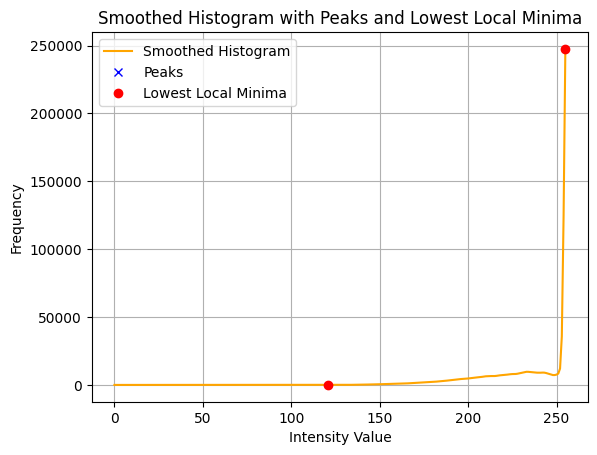

low_minimal:  [121 255]
Current Bound:  [  0 121 255]
new bound [  0.   0. 255.]
change bound [  0 121 255]  to  [  0.   0. 255.]


/var/folders/3w/mq_t4bjs35z7v0k7b_8tqs8h0000gn/T/ipykernel_6098/463130906.py:22: RuntimeWarning: invalid value encountered in divide
  pdf = sub_histo / sub_histo.sum()
/var/folders/3w/mq_t4bjs35z7v0k7b_8tqs8h0000gn/T/ipykernel_6098/463130906.py:34: RuntimeWarning: invalid value encountered in cast
  segment_cdf_normalized = np.round(cdf * (max_scale - min_scale) + min_scale).astype(int)


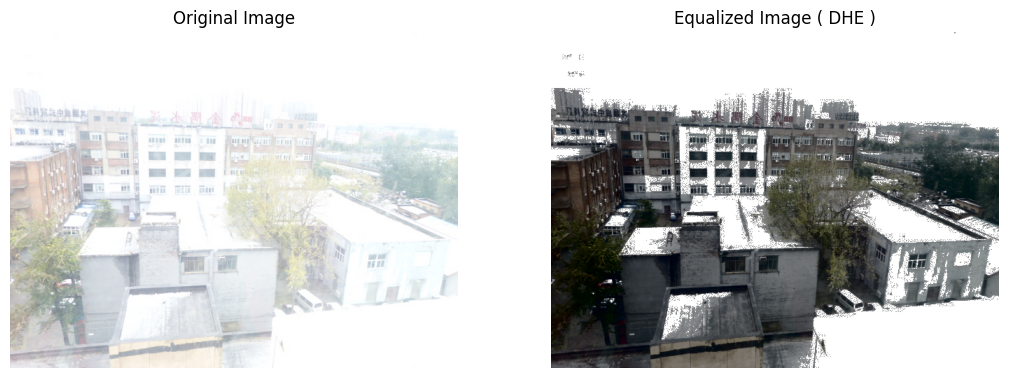

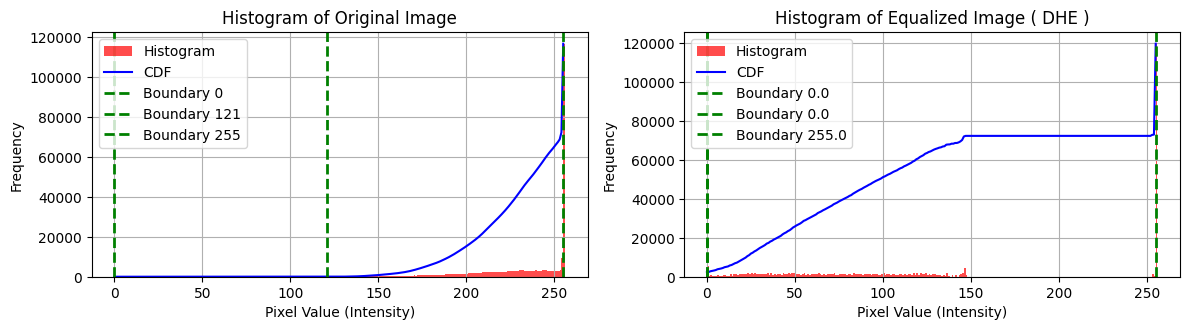

GL Range 0 255


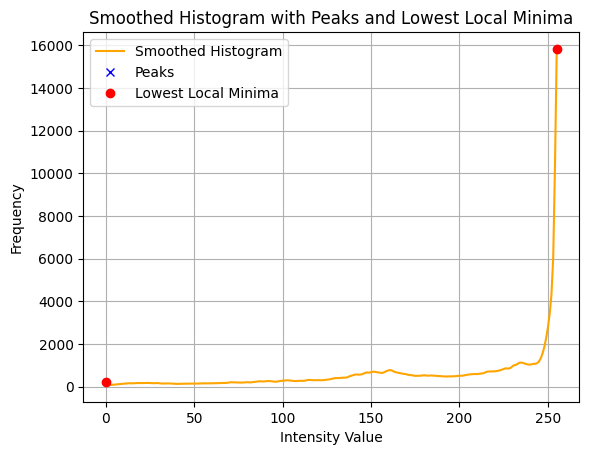

low_minimal:  [  0 255]
Current Bound:  [  0 255]
new bound [  0. 255.]
change bound [  0 255]  to  [  0. 255.]


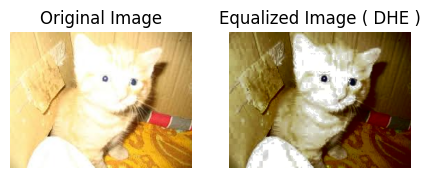

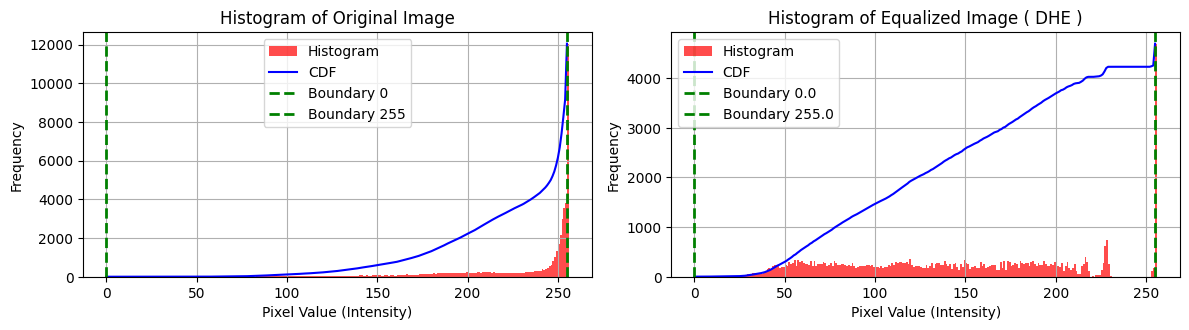

GL Range 51 255


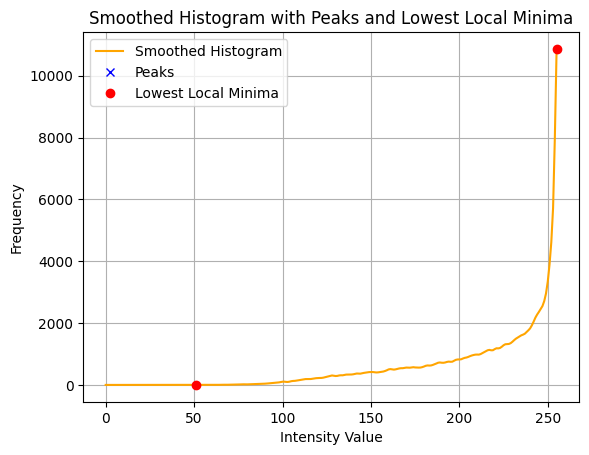

low_minimal:  [ 51 255]
Current Bound:  [  0  51 255]
new bound [  0.   0. 255.]
change bound [  0  51 255]  to  [  0.   0. 255.]


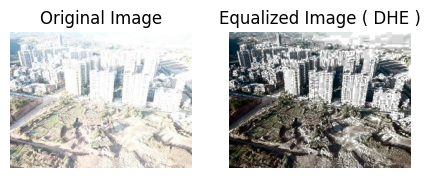

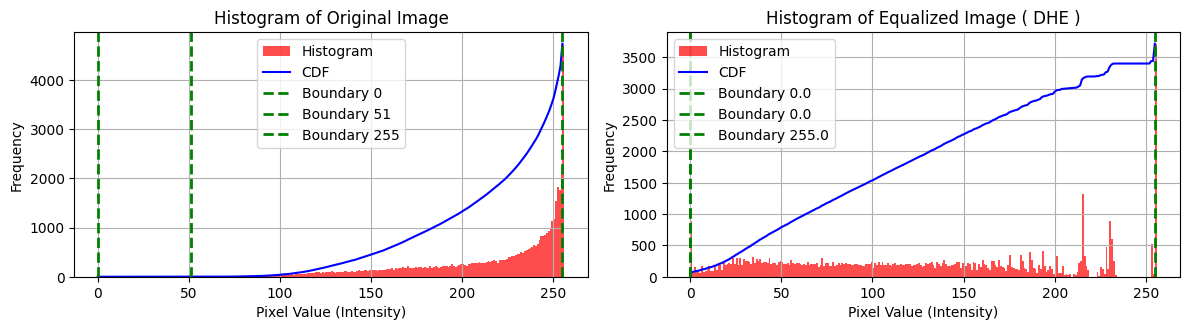

GL Range 141 255


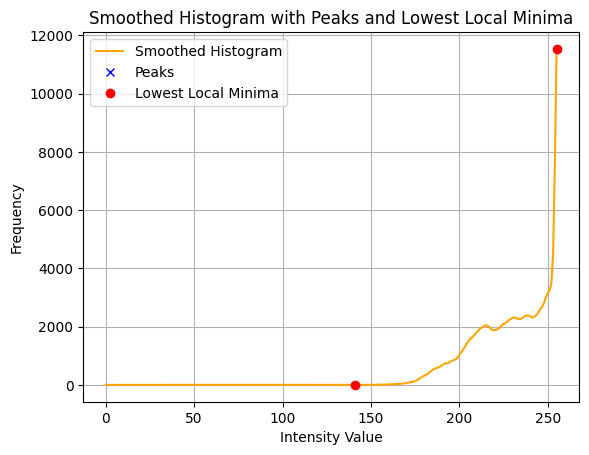

low_minimal:  [141 255]
Current Bound:  [  0 141 255]
new bound [  0.   0. 255.]
change bound [  0 141 255]  to  [  0.   0. 255.]


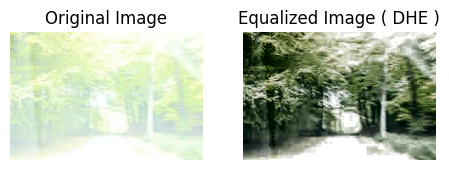

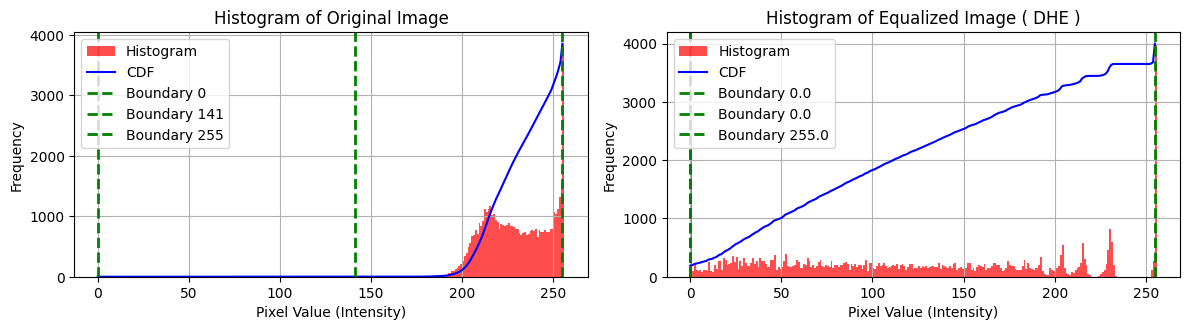

GL Range 0 225


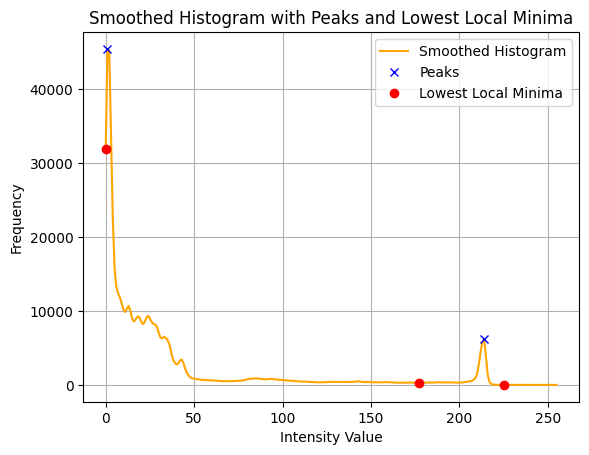

low_minimal:  [  0 177 225]
Current Bound:  [  0 177 225]
new bound [  0. 210. 255.]
change bound [  0 177 225]  to  [  0. 210. 255.]


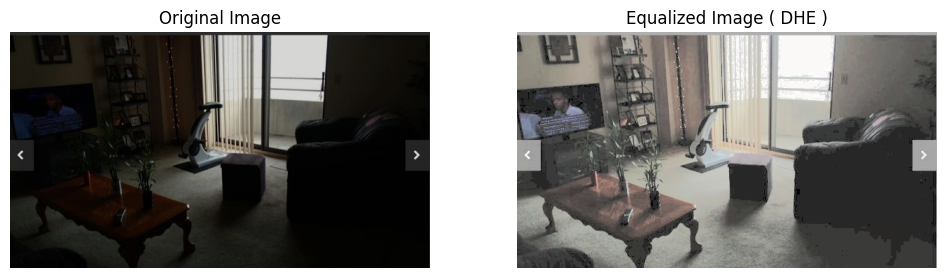

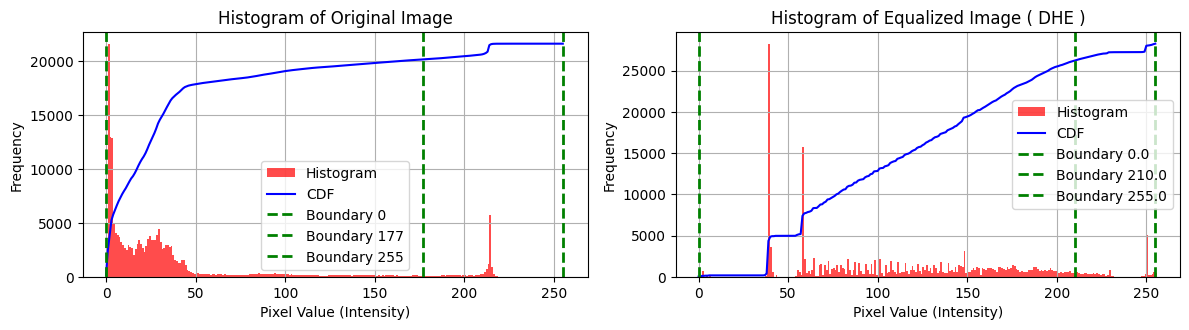

GL Range 0 255


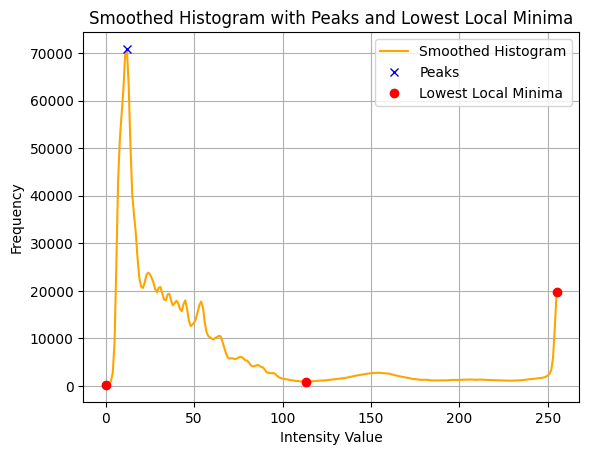

low_minimal:  [  0 113 255]
Current Bound:  [  0 113 255]
new bound [  0. 122. 255.]
change bound [  0 113 255]  to  [  0. 122. 255.]


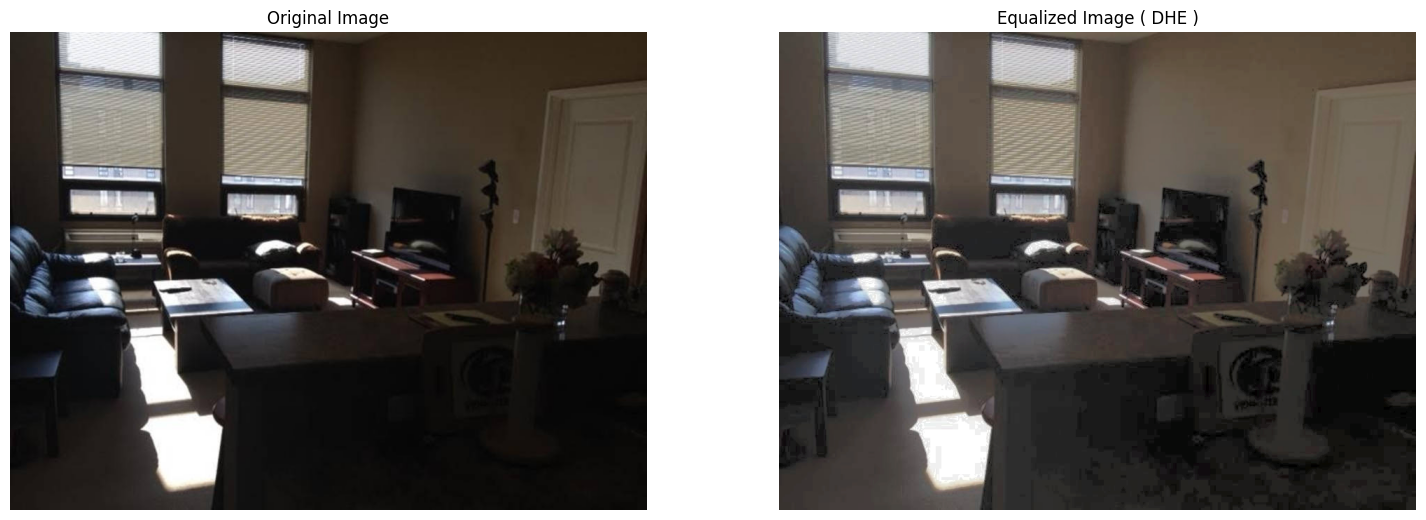

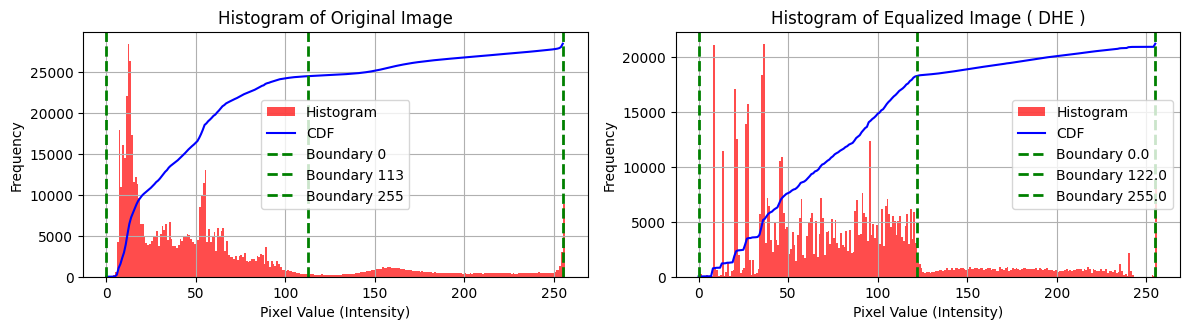

GL Range 0 255


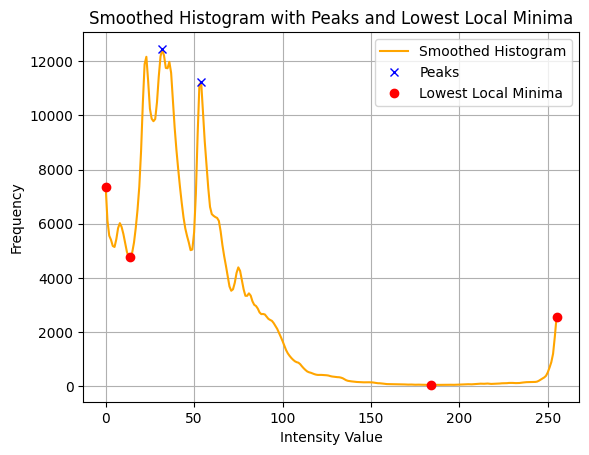

low_minimal:  [  0  14 184 255]
Current Bound:  [  0  14 184 255]
new bound [  0.  13. 200. 255.]
change bound [  0  14 184 255]  to  [  0.  13. 200. 255.]


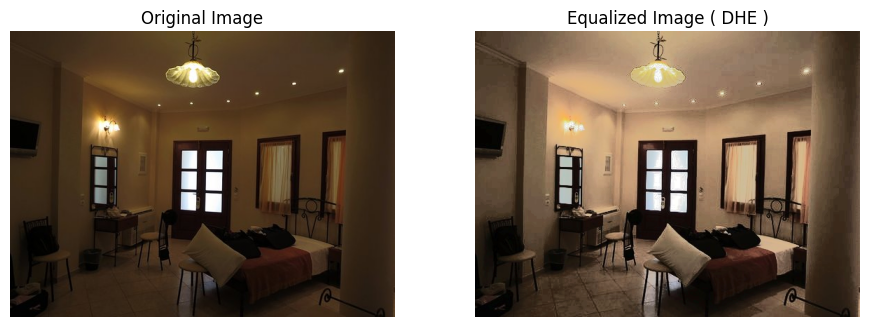

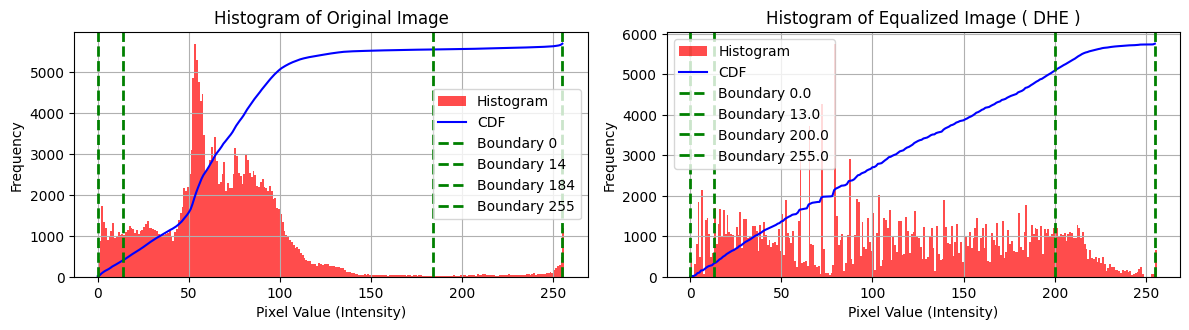

GL Range 0 255


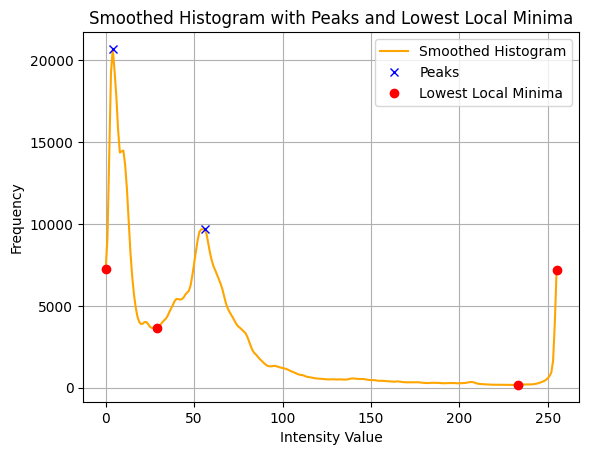

low_minimal:  [  0  29 233 255]
Current Bound:  [  0  29 233 255]
new bound [  0.  29. 239. 255.]
change bound [  0  29 233 255]  to  [  0.  29. 239. 255.]


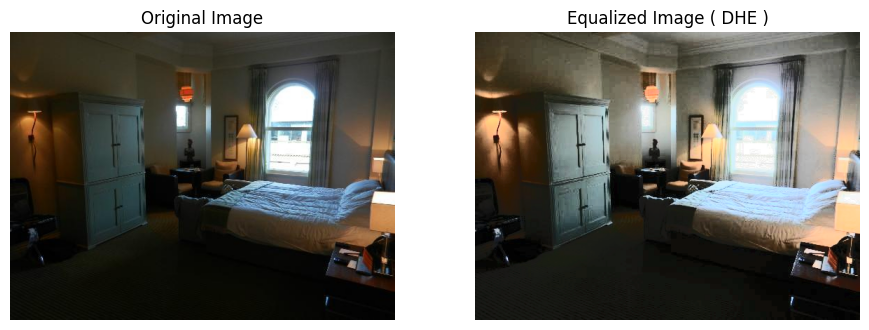

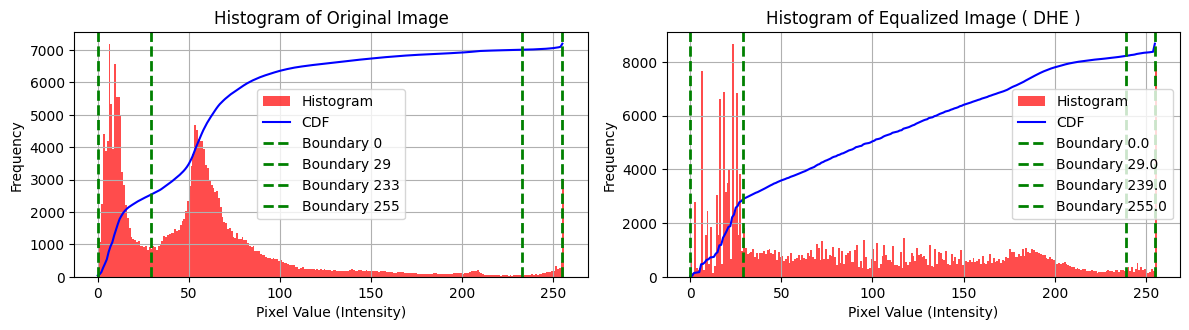

In [5]:
name = ["sample01.jpg", "sample02.jpeg", "sample03.jpeg", "sample04.jpeg",
          "sample05.jpeg", "sample06.jpg", "sample07.jpg", "sample08.jpg"]

for image_number, image_name in enumerate(name):
  image = cv2.imread(image_name)

  if image is None:
      print(f"Error: {image_name} could not be loaded.")
      continue

  # Convert the image to LAB color space
  lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

  # Split the LAB image into L, A, and B channels
  l_channel, a_channel, b_channel = cv2.split(lab_image)

  # find local minimal
  local_minimal = find_local_minimal(image)

  # dynamic define the boundary
  old_bound, new_bound = define_current_and_new_boundary(image, local_minimal)

  print("change bound", old_bound, " to ", new_bound)

  equalized_l_channel = new_dhe(l_channel, old_bound, new_bound)

  # Merge the channels back together
  equalized_lab = cv2.merge((equalized_l_channel, a_channel, b_channel))

  # Convert back to RGB color space
  equalized_rgb = cv2.cvtColor(equalized_lab, cv2.COLOR_LAB2BGR)

  plot_comparison_dhe_bound(image, equalized_rgb, old_bound, new_bound, title ="DHE")